# Paris Neighborhoods Analysis

## 0. Introduction and Problem statement

### Introduction

Paris, city and capital of France, is by far the country’s most important centre of commerce and culture. The 'city of Light' (la Ville Lumière) is one of the world's most important and attractive cities. It is particularly apreciated for its gastronomy which enjoys an enviable reputation.




### Problem statement

The choice of the location for a restaurant is the starting point, but also one of the most crucial decision. The success of the business can depend on this unique parameter. 
Each neighborhood has its own customer base, with its own habits.

The objective of this analysis is to help finding a good location, by analyzing different parameters like the type of venues nearby, the population base, and the property prices.

## 1. Analytic Approach

In order to determine the best location for opening a restaurant, we will first get the list of the neighborhoods and their geolocation, so that we can explore them using the Foursquare API and identify the different types of venues that are located nearby. We will then cluster the neighborhoods using k-means algorithm to better understand their particularities and identify which neighborhoods fit the most with a restaurant business.

We will then compare the neighborhoods using population data, so that we can shortlist the neighborhoods in which it would be relevant for opening a restaurant. For that we will determine a "target population" based on the age of our potential customer base. The assumptions on the "target population" are formulated later.

Our analysis will take into account the median rent of the neighborhoods as it can be one of the main costs for a restaurant. We will make the hypothesis of a lease for this analysis.

In summary, we will use for our analysis the following data :
* list of Paris neighborhoods
* Foursquare API to explore the neighborhoods and cluster them
* population size and characteristics for each neighborhood
* rent data of each neighborhood

## 2. Data Collection and Preparation

First we will import the relevant libraries for the project.

In [113]:
import pandas as pd
import numpy as np
import requests
import urllib.request
import time
import math
import seaborn as sns

!conda install --yes -c anaconda lxml

# !pip install BeautifulSoup4
# from bs4 import BeautifulSoup
import re

import json # library to handle JSON files


# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
# from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


### Collecting Neighborhoods list

First, we need Paris neighborhoods list. We can get it from data.gouv.fr, the french platform of public data.

In [114]:
# load Paris Neighborhoods table
df_neighborhoods = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/a3b31fdc-85dc-4aeb-94c6-a8b57aebef77', sep = ';')

# split the longitude and latitude data into 2 columns
df_neighborhoods['Latitude'] = df_neighborhoods['Geometry X Y'].str.split(",").str[0].astype(np.float64)
df_neighborhoods['Longitude'] = df_neighborhoods['Geometry X Y'].str.split(",").str[1].astype(np.float64)
df_neighborhoods = df_neighborhoods[['L_QU', 'C_AR', 'C_QUINSEE', 'SURFACE', 'Latitude', 'Longitude']]

# rename columns
df_neighborhoods.columns = ['Neighborhood', 'Borough', 'Neighborhood ID bis', 'Area [m2]', 'Latitude', 'Longitude']

df_neighborhoods

,Neighborhood,Borough,Neighborhood ID bis,Area [m2],Latitude,Longitude
0,Sainte-Avoie,3,7510304,2.133164e+05,48.862557,2.354852
1,Hôpital-Saint-Louis,10,7511004,8.837260e+05,48.876008,2.368123
2,Belleville,20,7512001,8.065686e+05,48.871531,2.387549
3,Ternes,17,7511701,1.465071e+06,48.881178,2.289964
4,Saint-Merri,4,7510401,3.130404e+05,48.858521,2.351667
...,...,...,...,...,...,...
75,Saint-Gervais,4,7510402,4.220282e+05,48.855719,2.358162
76,Saint-Thomas-d'Aquin,7,7510701,8.265594e+05,48.855263,2.325588
77,Porte-Saint-Denis,10,7511002,4.721136e+05,48.873618,2.352283
78,Saint-Germain-l'Auxerrois,1,7510101,8.690007e+05,48.860650,2.334910


Now let's visualize the neighborhoods in a map.

In [115]:
# get the geolocalisation of Paris
# address = 'Paris, France'

# geolocator = Nominatim(user_agent="Paris_explorer")
# location = geolocator.geocode(address)
# latitude = location.latitude
# longitude = location.longitude
# print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))
latitude = 48.8566969
longitude = 2.3514616


In [116]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map for each neighborhood
for lat, lng, borough, neighborhood in zip(df_neighborhoods['Latitude'], df_neighborhoods['Longitude'], 
                                           df_neighborhoods['Borough'], df_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  

map_paris

### Collecting neighborhoods rent price

In order to determine the best neighborhood for opening a restaurant and limit our costs, let's get the rent price of each neighborhood. For that, we can extract data from the same platform we used previously, data.gouv.fr.

In [117]:
# load and read the rent data
df_rent = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/d72d537a-2f7f-40af-bf1a-289ee25d5ae9', sep = ';')

# apply some transformations to the dataframe in order to merge it correctly with our neighborhoods dataframe
df_rent.rename(columns = {'Loyers de référence' : 'Median rent', 'Numéro INSEE du quartier' : 'Neighborhood ID'}, inplace = True)
df_rent['Neighborhood ID'] = df_rent['Neighborhood ID'].apply(str)

df_rent['Nom du quartier'].replace(["St-Germain-l'Auxerrois", "Javel 15Art", "Odeon", "Arts-et-Metiers", "Val-de-Grace"],
                                 ["Saint-Germain-l'Auxerrois", "Javel", "Odéon", "Arts-et-Métiers", "Val-de-Grâce"], inplace = True)

# group data by neighborhoods
df_rent = df_rent.groupby(['Nom du quartier', 'Neighborhood ID'])['Median rent'].mean().reset_index()
df_rent

,Nom du quartier,Neighborhood ID,Median rent
0,Amérique,7511975,20.600000
1,Archives,7510311,26.659375
2,Arsenal,7510415,27.915625
3,Arts-et-Métiers,7510309,26.659375
4,Auteuil,7511661,25.137500
...,...,...,...
75,Sorbonne,7510520,26.659375
76,Ternes,7511765,26.196875
77,Val-de-Grâce,7510519,26.659375
78,Villette,7511973,20.600000


In [118]:
# add the median rent column to our neighborhoods dataframe
df_neighborhoods = pd.merge(df_neighborhoods, df_rent, how = 'left', left_on = 'Neighborhood', right_on = 'Nom du quartier').drop('Nom du quartier', 1)
df_neighborhoods

,Neighborhood,Borough,Neighborhood ID bis,Area [m2],Latitude,Longitude,Neighborhood ID,Median rent
0,Sainte-Avoie,3,7510304,2.133164e+05,48.862557,2.354852,7510312,26.659375
1,Hôpital-Saint-Louis,10,7511004,8.837260e+05,48.876008,2.368123,7511040,23.687500
2,Belleville,20,7512001,8.065686e+05,48.871531,2.387549,7512077,23.687500
3,Ternes,17,7511701,1.465071e+06,48.881178,2.289964,7511765,26.196875
4,Saint-Merri,4,7510401,3.130404e+05,48.858521,2.351667,7510413,27.915625
...,...,...,...,...,...,...,...,...
75,Saint-Gervais,4,7510402,4.220282e+05,48.855719,2.358162,7510414,26.659375
76,Saint-Thomas-d'Aquin,7,7510701,8.265594e+05,48.855263,2.325588,7510725,29.575000
77,Porte-Saint-Denis,10,7511002,4.721136e+05,48.873618,2.352283,7511038,24.865625
78,Saint-Germain-l'Auxerrois,1,7510101,8.690007e+05,48.860650,2.334910,7510101,27.915625


One last information that could be useful is the population of each neighborhood, as we will compare the number of restaurants available by population in each neighborhood. We will get the data from a population census provided by INSEE, the french national institute of statistics and economic studies.

In [119]:
# load and read the population size data
file = r'data/base-ic-evol-struct-pop-2016.xls'
df_pop = pd.read_excel(file, sheet_name = 'IRIS', skiprows = 5)

In [120]:
# extract data for Paris and group by neighborhoods
df_pop = df_pop[df_pop['COM'].str.startswith('751')]
df_pop = df_pop.groupby('GRD_QUART').sum()
df_pop['Population'] = round(df_pop['P16_POP']).astype(int)
df_pop


,REG,MODIF_IRIS,P16_POP,P16_POP0002,P16_POP0305,P16_POP0610,P16_POP1117,P16_POP1824,P16_POP2539,P16_POP4054,...,C16_F15P_CS5,C16_F15P_CS6,C16_F15P_CS7,C16_F15P_CS8,P16_POP_FR,P16_POP_ETR,P16_POP_IMM,P16_PMEN,P16_PHORMEN,Population
GRD_QUART,,,,,,,,,,,,,,,,,,,,,
7510101,66,0,1401.367849,48.757088,27.788717,55.185812,86.587672,148.942187,304.333069,298.460042,...,102.754308,19.369679,111.580901,169.323277,1177.844006,223.523843,286.714849,1332.369160,68.998689,1401
7510102,66,0,8868.773185,235.821401,180.848901,360.844784,456.109690,915.595537,2446.233956,2018.979614,...,512.007674,72.118591,782.126596,718.751037,7657.043472,1211.729713,1599.893655,8702.776339,165.996846,8869
7510103,33,0,3239.424017,68.272257,67.522516,143.086502,170.804054,290.517810,781.449851,663.044841,...,208.254376,12.871589,324.143871,236.721825,2771.558343,467.865675,591.044945,3187.425005,51.999012,3239
7510104,22,0,2742.434949,55.899923,63.131922,115.103881,163.843301,231.026400,687.926484,585.870439,...,158.105227,29.713473,267.217247,217.884565,2343.695335,398.739613,498.467145,2734.435101,7.999848,2742
7510205,33,0,1456.111387,32.919822,41.445891,43.199541,85.082573,168.884968,392.460919,334.275729,...,103.935678,21.561973,97.702767,106.680803,1259.740812,196.370575,286.761707,1444.111118,12.000269,1456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7511976,187,0,41368.988440,1717.692841,1404.680465,2238.661201,2686.948198,3406.793419,10398.626841,8290.813217,...,2805.760210,397.820693,3966.799526,3137.051461,35736.696618,5632.291822,8574.716248,41084.655672,284.332768,41369
7512077,154,0,35604.705909,1194.758360,1103.533239,1728.645840,2637.925336,3129.362363,9416.003310,7749.768947,...,3021.421463,464.849944,2741.782147,2860.261804,29904.680113,5700.025796,8094.630040,35199.706626,404.999283,35605
7512078,176,0,46320.375609,1492.303546,1469.983429,2460.550355,3434.410302,3984.853130,10595.076446,10087.859956,...,3941.807538,566.044669,4627.206345,3496.711456,40157.053115,6163.322494,9614.622838,45513.377038,806.998571,46320


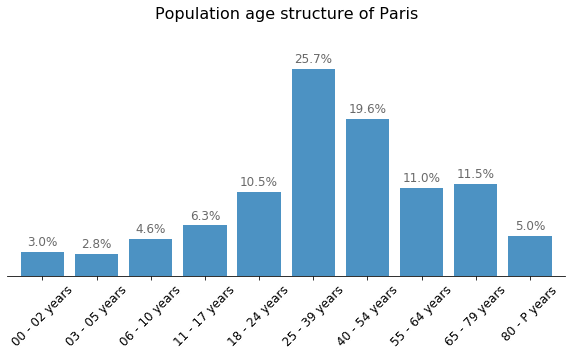

In [121]:
# visualize the age structure of the population of Paris
df_age = df_pop.iloc[:,3:13].sum().to_frame()
ax = df_age.plot(kind = 'bar', figsize = (10, 4), width = 0.8, alpha = 0.8)

# ax.set_title('Population age structure of Paris (in thousands)', fontsize=16, pad = 40)    
ax.set_title('Population age structure of Paris', fontsize=16, pad = 40)  
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_yaxis().set_visible(False)
ax.xaxis.set_label_text("")

age_categories = [ name[7:9]+ ' - ' + name[9::] + ' years' for name in df_age.index.tolist() ]
ax.set_xticklabels(age_categories)

ax.tick_params(axis='x', labelsize=12, rotation = 45)
ax.get_legend().remove()

for bar in ax.patches:
    val = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + df_age.max()*(0.03) , str(round(val * 100 /df_age.sum().item(), 1)) + '%', 
            ha='center', color='dimgrey', fontsize=12)
    
# for bar in ax.patches:
#     val = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + df_age.max()*(0.03) , str(int(val/1000)), 
#             ha='center', color='dimgrey', fontsize=12)

In [122]:
# calculate a weighted population that we will consider to be our target population. This is done by considering the population age
weight = {'P16_POP1117' : 0.05, 'P16_POP1824' : 0.2, 'P16_POP2539' : 0.5, 'P16_POP4054' : 0.2, 'P16_POP5564' : 0.05}
df_pop['Target Population'] = round( (df_pop.loc[:,weight.keys()] * list(weight.values())).sum(axis=1) ).astype(int)

# select the needed columns
df_pop = df_pop[['Population', 'Target Population']]
df_pop

,Population,Target Population
GRD_QUART,,
7510101,1401,256
7510102,8869,1877
7510103,3239,607
7510104,2742,531
7510205,1456,312
...,...,...
7511976,41369,7905
7512077,35605,7213
7512078,46320,8548


In [123]:
# add the population size columns to our neighborhoods dataframe
df_neighborhoods = pd.merge(df_neighborhoods, df_pop, how = 'left', left_on = 'Neighborhood ID', right_index = True)
df_neighborhoods['Density per km2'] = round(df_neighborhoods['Population'] / (df_neighborhoods['Area [m2]'] * (10**(-6)))).astype(int)
df_neighborhoods

,Neighborhood,Borough,Neighborhood ID bis,Area [m2],Latitude,Longitude,Neighborhood ID,Median rent,Population,Target Population,Density per km2
0,Sainte-Avoie,3,7510304,2.133164e+05,48.862557,2.354852,7510312,26.659375,7895,1839,37011
1,Hôpital-Saint-Louis,10,7511004,8.837260e+05,48.876008,2.368123,7511040,23.687500,29060,6396,32883
2,Belleville,20,7512001,8.065686e+05,48.871531,2.387549,7512077,23.687500,35605,7213,44144
3,Ternes,17,7511701,1.465071e+06,48.881178,2.289964,7511765,26.196875,38576,7424,26330
4,Saint-Merri,4,7510401,3.130404e+05,48.858521,2.351667,7510413,27.915625,6074,1217,19403
...,...,...,...,...,...,...,...,...,...,...,...
75,Saint-Gervais,4,7510402,4.220282e+05,48.855719,2.358162,7510414,26.659375,9668,2005,22908
76,Saint-Thomas-d'Aquin,7,7510701,8.265594e+05,48.855263,2.325588,7510725,29.575000,11026,1748,13340
77,Porte-Saint-Denis,10,7511002,4.721136e+05,48.873618,2.352283,7511038,24.865625,16254,3805,34428
78,Saint-Germain-l'Auxerrois,1,7510101,8.690007e+05,48.860650,2.334910,7510101,27.915625,1401,256,1612


### Getting the categories of venues given in the Foursquare API

In the next steps, we will search for the different venues nearby each of the neighborhoods using Foursquare API. The API provides the venues and their subcategories, such as 'Japanese Restaurant'. For our analysis, we need the category, which would be in this case 'Food'.
Therefore we need to get the relationship table between subcategories and categories using the API.

In [124]:
# Define Foursquare credentials and the API version
CLIENT_ID = 'MSGJVICNEPASDZ1BOL1YXIQJUHQCE1XWNBYH40A3RT0LHXWY' # your Foursquare ID
CLIENT_SECRET = 'LBPHWJG3CE4VB4SFXGG3G0SHELTH50OXUUEU5PGZLUN0GMQD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 30
radius = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MSGJVICNEPASDZ1BOL1YXIQJUHQCE1XWNBYH40A3RT0LHXWY
CLIENT_SECRET:LBPHWJG3CE4VB4SFXGG3G0SHELTH50OXUUEU5PGZLUN0GMQD


In [125]:
# get the API url for requesting the categories hierarchy
url_categories = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

There are 10 categories in the Foursquare API. The API response provides a json file that we need to parse to get the categories list. 

In [126]:
# get the json file and retrieve the categories list from it
response_categories = requests.get(url_categories).json()
categories_json = response_categories['response']['categories']

categories_name = pd.json_normalize(categories_json)[['name']]
categories_name

,name
0,Arts & Entertainment
1,College & University
2,Event
3,Food
4,Nightlife Spot
5,Outdoors & Recreation
6,Professional & Other Places
7,Residence
8,Shop & Service
9,Travel & Transport


Now we have to flatten the json file in order to get the relationship between the categories and subcategories lists. In total, there are 746 subcategories found in the API.

In [127]:
# function to flatten the nested json file
def flatten_json(nested_json):
    """
        Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(nested_json)
    return out


# convert the flatten nested json file to dataframe
df = pd.Series(flatten_json(categories_json)).to_frame().reset_index()

# parse data from the flatten json file
df.columns = ['name', 'value']
df['category id'], df['B'], df['C'], df['D'] = df['name'].str.split('_', 3).str
df_categories = df.loc[df['D'].str.contains('name', na = False)][['value', 'category id']].reset_index(drop = True)
df_categories['category id'] = df_categories['category id'].astype(int)

# merge the subcategory dataframe with the category datagrame to build the final category relationship table
categories = pd.merge(df_categories, categories_name, how = 'left', left_on = 'category id', right_index = True).drop('category id', 1)
categories.columns = ['subcategory name', 'category name']

categories

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: Columnar iteration over characters will be deprecated in future releases.


,subcategory name,category name
0,Amphitheater,Arts & Entertainment
1,Aquarium,Arts & Entertainment
2,Arcade,Arts & Entertainment
3,Art Gallery,Arts & Entertainment
4,Bowling Alley,Arts & Entertainment
...,...,...
741,Train,Travel & Transport
742,Tram Station,Travel & Transport
743,Transportation Service,Travel & Transport
744,Travel Lounge,Travel & Transport


### Exploring the venues of each neighborhood using the Foursquare API

Now that we have the Foursquare category table, we can now explore the neighborhoods using the API.

In [128]:
# function that clean the json file, structure it into a dataframe containing the venues found for each Neighborhood
def getNearbyVenues(names, latitudes, longitudes, neigh_area):
    
    venues_list=[]
    for name, lat, lng, area in zip(names, latitudes, longitudes, neigh_area):
        
        # calculate the radius of the API exploration request depending on the area of the neighborhood
        radius = math.sqrt(area)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [129]:
# apply the function for each neighborhood
Paris_venues = getNearbyVenues(names=df_neighborhoods['Neighborhood'],
                                   latitudes=df_neighborhoods['Latitude'],
                                   longitudes=df_neighborhoods['Longitude'],
                                   neigh_area = df_neighborhoods['Area [m2]']
                                  )
print(Paris_venues.shape)
Paris_venues

(2400, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Sainte-Avoie,48.862557,2.354852,Laïzé 來座 (Laïzé),48.863077,2.355073,Bubble Tea Shop
1,Sainte-Avoie,48.862557,2.354852,François Pralus,48.861072,2.353806,Gourmet Shop
2,Sainte-Avoie,48.862557,2.354852,Causses - Le magasin d'alimentation,48.864020,2.353058,Deli / Bodega
3,Sainte-Avoie,48.862557,2.354852,Huré,48.860915,2.354640,Bakery
4,Sainte-Avoie,48.862557,2.354852,Hôtel Jules & Jim,48.863496,2.357395,Hotel
...,...,...,...,...,...,...,...
2395,Villette,48.887661,2.374468,Rotonde de la Villette,48.883450,2.369528,Historic Site
2396,Villette,48.887661,2.374468,Les Bancs Publics,48.890977,2.383923,Bistro
2397,Villette,48.887661,2.374468,La Guincheuse,48.883309,2.367846,Lounge
2398,Villette,48.887661,2.374468,Point Éphémère,48.881538,2.368780,Bar


Now we can retrieve the category of each venue using our category table.

In [130]:
# get the category name from the category table
Paris_venues = pd.merge(Paris_venues, categories, how = 'left', left_on = 'Venue Category', right_on = 'subcategory name').drop('subcategory name' , 1)

# drop rows for which the category has not been found (due to a category list not updated by Foursquare)
Paris_venues.dropna(inplace = True)
Paris_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,category name
0,Sainte-Avoie,48.862557,2.354852,Laïzé 來座 (Laïzé),48.863077,2.355073,Bubble Tea Shop,Food
1,Sainte-Avoie,48.862557,2.354852,François Pralus,48.861072,2.353806,Gourmet Shop,Shop & Service
2,Sainte-Avoie,48.862557,2.354852,Causses - Le magasin d'alimentation,48.864020,2.353058,Deli / Bodega,Food
3,Sainte-Avoie,48.862557,2.354852,Huré,48.860915,2.354640,Bakery,Food
4,Sainte-Avoie,48.862557,2.354852,Hôtel Jules & Jim,48.863496,2.357395,Hotel,Travel & Transport


In [131]:
print('There are {} uniques categories.'.format(len(Paris_venues['Venue Category'].unique())))

There are 218 uniques categories.


Now we have to transform a little bit our data in order to apply our k-means cluster algorithm. First we will put into columns each one of our categories.

In [132]:
# one hot encoding
Paris_onehot = pd.get_dummies(Paris_venues[['category name']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# Paris_onehot.drop(['Neighborhood'], axis = 1, inplace = True)
Paris_onehot['Neighborhood'] = Paris_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Paris_onehot.columns[-1]] + list(Paris_onehot.columns[:-1])
Paris_onehot = Paris_onehot[fixed_columns]

Paris_onehot.head()

,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Sainte-Avoie,0,1,0,0,0,0,0
1,Sainte-Avoie,0,0,0,0,0,1,0
2,Sainte-Avoie,0,1,0,0,0,0,0
3,Sainte-Avoie,0,1,0,0,0,0,0
4,Sainte-Avoie,0,0,0,0,0,0,1


Let's regroup our data by neighborhood in order to count for each neighborhood the number of venues found for the different categories.

In [133]:
# sum for each neighborhood the number of venues of different categories
Paris_sum = Paris_onehot.groupby('Neighborhood').sum().reset_index()
Paris_sum

,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Amérique,3,16,2,6,1,1,1
1,Archives,2,14,1,2,1,8,1
2,Arsenal,2,14,2,8,0,2,2
3,Arts-et-Métiers,3,19,3,0,0,2,3
4,Auteuil,6,8,0,12,1,2,1
...,...,...,...,...,...,...,...,...
75,Sorbonne,1,17,1,4,1,5,1
76,Ternes,0,20,2,2,0,3,3
77,Val-de-Grâce,2,19,2,2,2,2,1
78,Villette,4,13,8,2,0,1,2


Now we can calculate the frequency of occurrence of each category within one neighborhood.

In [134]:
# calculate the frequency of occurrence of each category within one neighborhood
Paris_grouped = Paris_onehot.groupby('Neighborhood').mean().reset_index()
Paris_grouped

,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Amérique,0.100000,0.533333,0.066667,0.200000,0.033333,0.033333,0.033333
1,Archives,0.068966,0.482759,0.034483,0.068966,0.034483,0.275862,0.034483
2,Arsenal,0.066667,0.466667,0.066667,0.266667,0.000000,0.066667,0.066667
3,Arts-et-Métiers,0.100000,0.633333,0.100000,0.000000,0.000000,0.066667,0.100000
4,Auteuil,0.200000,0.266667,0.000000,0.400000,0.033333,0.066667,0.033333
...,...,...,...,...,...,...,...,...
75,Sorbonne,0.033333,0.566667,0.033333,0.133333,0.033333,0.166667,0.033333
76,Ternes,0.000000,0.666667,0.066667,0.066667,0.000000,0.100000,0.100000
77,Val-de-Grâce,0.066667,0.633333,0.066667,0.066667,0.066667,0.066667,0.033333
78,Villette,0.133333,0.433333,0.266667,0.066667,0.000000,0.033333,0.066667


Let's visualize the frequancy of the results in a boxplot.

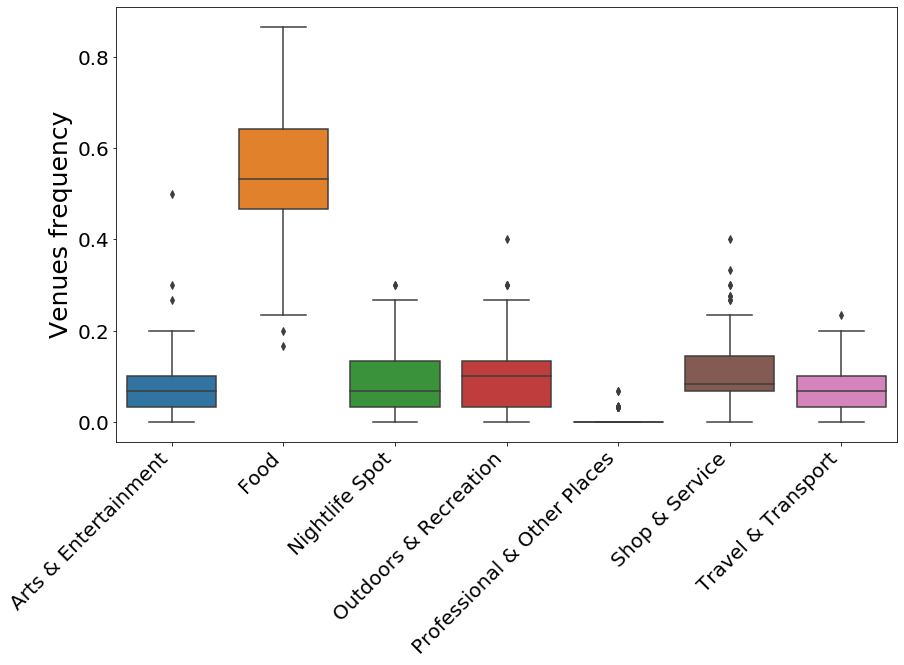

In [135]:
# create a boxplot representing the frequency of venues of each categories
plt.figure(figsize=(14,8))
ax = sns.boxplot(data = Paris_grouped)
ax.set_ylabel('Venues frequency', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

We can see that "Food" venues has a large place in Paris venues, as we could predict. The other types of venues are quite balanced, with the "professional & other places" category almost not represented, which is not really accurate. Indeed there is an important business district located just outside of the city, which explains that we don't have that many professional places inside the city. But there should be nonetheless a significant number of them that the API should have returned. This lack can be explained by the fact that people do not usually "check in" in those kind of places when using the Foursquare application.

That being said, this missing information is not crucial to our project, as there is no real business district inside the city, but a rather scattered professional places throughout it.

In [136]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [137]:
# select the number of most common venues that we want to display in the dataframe
num_top_venues = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Paris_grouped['Neighborhood']

# fill the dataframe with the columns we need
for ind in np.arange(Paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted
    

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Amérique,Food,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,Travel & Transport,Shop & Service,Professional & Other Places
1,Archives,Food,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,Professional & Other Places,Nightlife Spot
2,Arsenal,Food,Outdoors & Recreation,Travel & Transport,Shop & Service,Nightlife Spot,Arts & Entertainment,Professional & Other Places
3,Arts-et-Métiers,Food,Travel & Transport,Nightlife Spot,Arts & Entertainment,Shop & Service,Professional & Other Places,Outdoors & Recreation
4,Auteuil,Outdoors & Recreation,Food,Arts & Entertainment,Shop & Service,Travel & Transport,Professional & Other Places,Nightlife Spot
...,...,...,...,...,...,...,...,...
75,Sorbonne,Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Professional & Other Places,Nightlife Spot,Arts & Entertainment
76,Ternes,Food,Travel & Transport,Shop & Service,Outdoors & Recreation,Nightlife Spot,Professional & Other Places,Arts & Entertainment
77,Val-de-Grâce,Food,Shop & Service,Professional & Other Places,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,Travel & Transport
78,Villette,Food,Nightlife Spot,Arts & Entertainment,Travel & Transport,Outdoors & Recreation,Shop & Service,Professional & Other Places


## 3. Modeling

### Clustering Paris neighborhoods using K-means

Before going through the k-means algorithm, we will determine an appropriate number of clusters using the Elbow method.

In [138]:
# drop the neighborhood column in order to have numeric values only
Paris_grouped_clustering = Paris_grouped.drop('Neighborhood', 1)

In [179]:
# proceed to the clusterisation with multiple K (from 1 to 15) and save the sum of squared distance calculated for each K
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Paris_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_) 

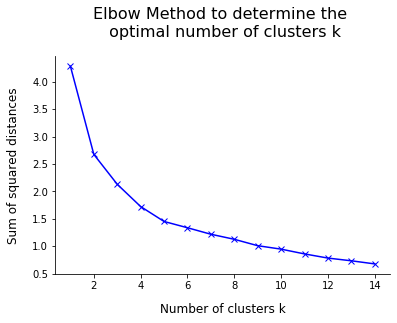

In [180]:
# visualize the sum of squared distance for the different Ks used
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.title('Elbow Method to determine the \n optimal number of clusters k', fontsize=16, pad = 20)
plt.xlabel('Number of clusters k', fontsize=12, labelpad = 12)
plt.ylabel('Sum of squared distances', fontsize=12, labelpad = 12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

We can see that a suitable number of cluster would be between 3 and 5. After this value, the information gained by adding clusters is too marginal and will make our analysis too complex. For the sake of our analysis, we will consider 3 clusters as we can understand and interpret them more easily.

Now that we determined our number of clusters, we can apply a k-means algorithm to our dataset.

In [141]:
# run k-means to cluster the neighborhoods into 3 clusters
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=6, n_init = 1000).fit(Paris_grouped_clustering)

# calculate sum of squared distances (SSE)
kmeans.inertia_

2.1131253283643296

## 4. Data Analysis and interpretation

Let's add the cluster information to our neighborhood table.

In [142]:
# add the cluster column to the neighborhood dataframe
Paris_clustered = Paris_grouped.copy()
Paris_clustered.insert(0, 'Cluster', kmeans.labels_)
Paris_clustered

,Cluster,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,0,Amérique,0.100000,0.533333,0.066667,0.200000,0.033333,0.033333,0.033333
1,0,Archives,0.068966,0.482759,0.034483,0.068966,0.034483,0.275862,0.034483
2,0,Arsenal,0.066667,0.466667,0.066667,0.266667,0.000000,0.066667,0.066667
3,2,Arts-et-Métiers,0.100000,0.633333,0.100000,0.000000,0.000000,0.066667,0.100000
4,1,Auteuil,0.200000,0.266667,0.000000,0.400000,0.033333,0.066667,0.033333
...,...,...,...,...,...,...,...,...,...
75,0,Sorbonne,0.033333,0.566667,0.033333,0.133333,0.033333,0.166667,0.033333
76,2,Ternes,0.000000,0.666667,0.066667,0.066667,0.000000,0.100000,0.100000
77,2,Val-de-Grâce,0.066667,0.633333,0.066667,0.066667,0.066667,0.066667,0.033333
78,0,Villette,0.133333,0.433333,0.266667,0.066667,0.000000,0.033333,0.066667


In [143]:
# add clustering labels
if 'Cluster' not in neighborhoods_venues_sorted :
    neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans.labels_)

Paris_merged = df_neighborhoods.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Paris_merged = Paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Paris_merged.head() # check the last columns!

,Neighborhood,Borough,Neighborhood ID bis,Area [m2],Latitude,Longitude,Neighborhood ID,Median rent,Population,Target Population,Density per km2,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Sainte-Avoie,3,7510304,2.133164e+05,48.862557,2.354852,7510312,26.659375,7895,1839,37011,2,Food,Shop & Service,Nightlife Spot,Arts & Entertainment,Travel & Transport,Outdoors & Recreation,Professional & Other Places
1,Hôpital-Saint-Louis,10,7511004,8.837260e+05,48.876008,2.368123,7511040,23.687500,29060,6396,32883,2,Food,Outdoors & Recreation,Nightlife Spot,Shop & Service,Travel & Transport,Professional & Other Places,Arts & Entertainment
2,Belleville,20,7512001,8.065686e+05,48.871531,2.387549,7512077,23.687500,35605,7213,44144,2,Food,Nightlife Spot,Shop & Service,Arts & Entertainment,Outdoors & Recreation,Travel & Transport,Professional & Other Places
3,Ternes,17,7511701,1.465071e+06,48.881178,2.289964,7511765,26.196875,38576,7424,26330,2,Food,Travel & Transport,Shop & Service,Outdoors & Recreation,Nightlife Spot,Professional & Other Places,Arts & Entertainment
4,Saint-Merri,4,7510401,3.130404e+05,48.858521,2.351667,7510413,27.915625,6074,1217,19403,0,Food,Shop & Service,Arts & Entertainment,Outdoors & Recreation,Nightlife Spot,Travel & Transport,Professional & Other Places


Let's compare the neighborhoods using a box plot.

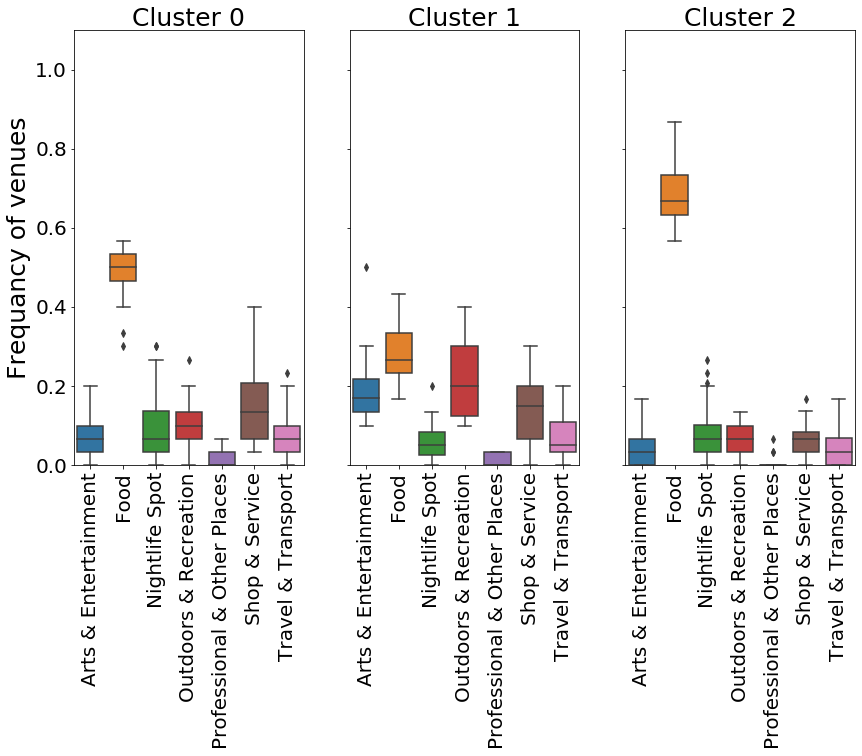

In [144]:
# visualize the frequency of venues in each cluster using box plot
fig,axes= plt.subplots(1,kclusters,figsize=(14,8),sharey=True)

axes[0].set_ylabel('Frequancy of venues', fontsize=25)

for k in range(0, kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = Paris_clustered[Paris_clustered['Cluster'] == k].drop('Cluster',1), ax=axes[k])

We can see that cluster 0 and 2 are dominated by "Food" venues, whereas the cluster 1 is more balanced. We can therefore discard cluster 1 from our analysis as it does not seem to be adapted to our business.

But this analysis is not enough as we only consider the absolute number of venues, and do not take into account the neighborhoods density. For that, we will compare them using population data.

In [145]:
# insert the cluster column to the Paris_sum dataframe
Paris_sum_clustered = Paris_sum.copy()
Paris_sum_clustered.insert(0, 'Cluster', kmeans.labels_)

# add population data to the dataframe
Paris_sum_clustered = pd.merge(Paris_sum_clustered, df_neighborhoods[['Neighborhood', 'Population', 'Target Population', 'Latitude', 'Longitude', 'Median rent']], 
                               how = 'left', left_on = 'Neighborhood', right_on = 'Neighborhood')

# calculate the number of Food venues for 1000 population 
Paris_sum_clustered['Food by 1000 population targeted'] = round(Paris_sum_clustered['Food'] / Paris_sum_clustered['Population'] * 1000, 2)
Paris_sum_clustered

,Cluster,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Population,Target Population,Latitude,Longitude,Median rent,Food by 1000 population targeted
0,0,Amérique,3,16,2,6,1,1,1,57924,10468,48.881638,2.395440,20.600000,0.28
1,0,Archives,2,14,1,2,1,8,1,8175,1684,48.859192,2.363205,26.659375,1.71
2,0,Arsenal,2,14,2,8,0,2,2,8718,1698,48.851585,2.364768,27.915625,1.61
3,2,Arts-et-Métiers,3,19,3,0,0,2,3,9722,2265,48.866470,2.357083,26.659375,1.95
4,1,Auteuil,6,8,0,12,1,2,1,71708,11280,48.850622,2.252277,25.137500,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0,Sorbonne,1,17,1,4,1,5,1,9811,1841,48.849045,2.345747,26.659375,1.73
76,2,Ternes,0,20,2,2,0,3,3,38576,7424,48.881178,2.289964,26.196875,0.52
77,2,Val-de-Grâce,2,19,2,2,2,2,1,19668,3482,48.841684,2.343861,26.659375,0.97
78,0,Villette,4,13,8,2,0,1,2,55348,10514,48.887661,2.374468,20.600000,0.23


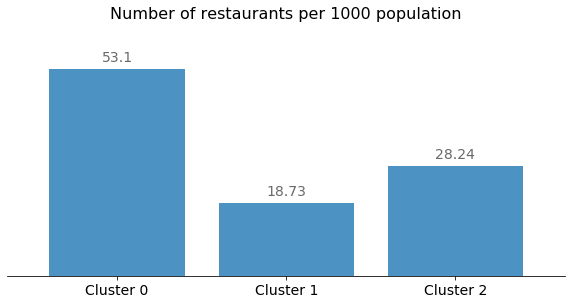

In [146]:
# visualize the number of Food venues for 1000 population in each cluster using box plot
Paris_sum_grouped = Paris_sum_clustered.groupby('Cluster')['Food by 1000 population targeted'].sum()
# Paris_sum_grouped.plot(kind = 'bar')

ax = Paris_sum_grouped.plot(kind = 'bar', figsize = (10, 4), x = 'Cluster', width = 0.8, alpha = 0.8)

ax.set_title('Number of restaurants per 1000 population', fontsize=16, pad = 40)            
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_yaxis().set_visible(False)
ax.xaxis.set_label_text("")
ax.set_xticklabels(['Cluster 0', 'Cluster 1', 'Cluster 2'])

ax.tick_params(axis='x', labelsize=14, rotation = 0)
# ax.get_legend().remove()

for bar in ax.patches:
    val = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2 , str(round(val, 2)), 
            ha='center', color='dimgrey', fontsize=14)
    

The results show that cluster 0 contains the largest number of restaurants with regards to the population. It would then be difficult to succeed considering the fierce competition we would face, especially if we want to open a new restaurant, and not just buy an existing one (in which case, this cluster would be a good option to consider).

The most secured option would then be neighborhoods in the cluster 2.

Now let's visualize our clusters in a map. We will also add rent data using a choropleth map.

In [147]:
# loads a json file containing the polygons geolocalisation data of each neighborhood for the choropleth nap
paris_json = r'https://www.data.gouv.fr/fr/datasets/r/a8748f53-5850-4a04-b8cc-9c9f5f72949f'

In [148]:
# create map of Paris using latitude and longitude values
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# add neighborhoods median rent data to the map
map_clusters.choropleth(
    geo_data=paris_json,
    data=df_neighborhoods,
    columns=['Neighborhood', 'Median rent'],
    key_on='feature.properties.l_qu',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Median rent by neighborhood'
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map representing the neighborhoods
markers_colors = []
for lat, lon, poi, cluster in zip(Paris_merged['Latitude'], Paris_merged['Longitude'], Paris_merged['Neighborhood'], Paris_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As we can see, some of the neighborhoods of cluster 2 have a high rent price. Let's select neighborhoods in which the rent price is below 25€ per m2.

In [149]:
# extract the selected neighborhoods
df_selected_neigh = Paris_sum_clustered[(Paris_sum_clustered['Cluster'] == 2) & (Paris_sum_clustered['Median rent'] <= 25)]
df_selected_neigh.head()

,Cluster,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Population,Target Population,Latitude,Longitude,Median rent,Food by 1000 population targeted
5,2,Batignolles,0,22,3,3,0,2,0,42302,9708,48.888482,2.313856,24.787500,0.52
7,2,Belleville,2,18,6,1,0,3,0,35605,7213,48.871531,2.387549,23.687500,0.51
14,2,Clignancourt,0,22,5,1,0,2,0,68873,15953,48.891668,2.345979,22.875000,0.32
15,2,Combat,1,21,4,4,0,0,0,41369,7905,48.878639,2.380127,22.437500,0.51
16,2,Croulebarbe,3,19,2,1,0,3,2,20793,3671,48.833734,2.347673,24.865625,0.91


Now let's visualize the selected neighborhoods.

In [150]:
# create map of Paris using latitude and longitude values
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# add neighborhoods median rent data to the map
map_clusters.choropleth(
    geo_data=paris_json,
    data=df_neighborhoods,
    columns=['Neighborhood', 'Median rent'],
    key_on='feature.properties.l_qu',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Median rent by neighborhood'
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map representing the selected neighborhoods
markers_colors = []
for lat, lon, poi, cluster in zip(df_selected_neigh['Latitude'], df_selected_neigh['Longitude'], df_selected_neigh['Neighborhood'], df_selected_neigh['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.7).add_to(map_clusters)
        
map_clusters

Now let's compare the selected neighborhoods with regrards to their population size to see if we can exclude some of them.

In [151]:
# extract the Food by 1000 population targeted column for further analysis
df_selected_neigh = df_selected_neigh[['Neighborhood', 'Food by 1000 population targeted']]
df_selected_neigh

,Neighborhood,Food by 1000 population targeted
5,Batignolles,0.52
7,Belleville,0.51
14,Clignancourt,0.32
15,Combat,0.51
16,Croulebarbe,0.91
19,Epinettes,0.44
21,Faubourg-Montmartre,1.69
23,Folie-Méricourt,0.57
25,Gare,0.25
26,Goutte-d'Or,0.59


In [152]:
# analyze the data and calculate 1st and 3rd quartiles
quart_1 = np.percentile(df_selected_neigh['Food by 1000 population targeted'], 25)
quart_3 = np.percentile(df_selected_neigh['Food by 1000 population targeted'], 75)
df_selected_neigh.describe()

,Food by 1000 population targeted
count,26.000000
mean,0.675769
std,0.364792
min,0.240000
25%,0.395000
50%,0.580000
75%,0.932500
max,1.690000


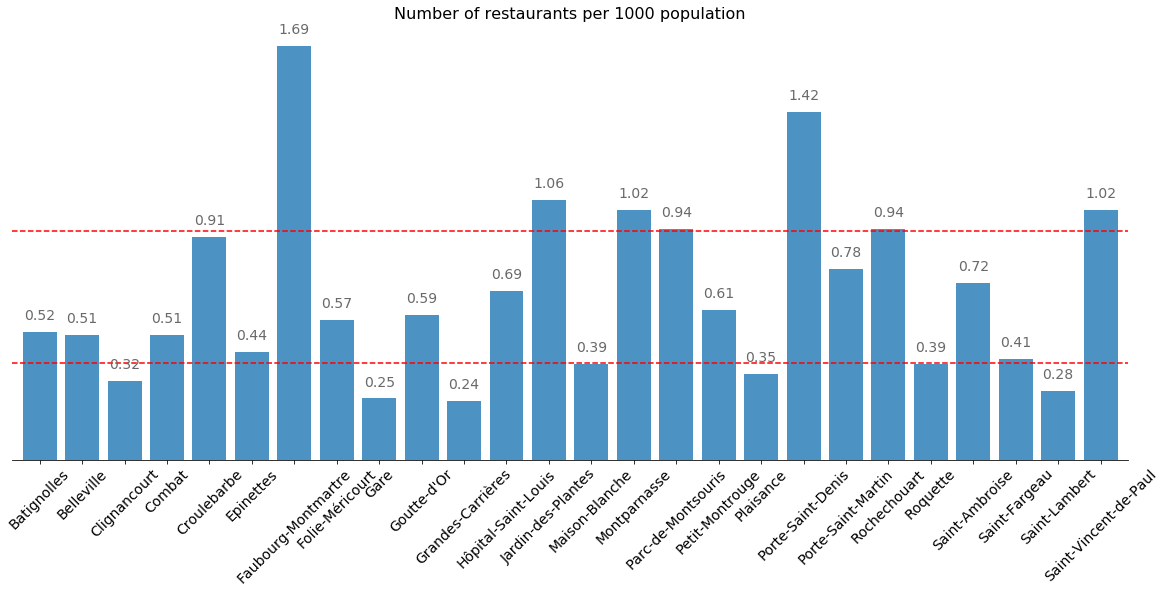

In [153]:
# visualize the number of restaurants per 1000 population
ax = df_selected_neigh.plot(kind = 'bar', figsize = (20, 8), x = 'Neighborhood', width = 0.8, alpha = 0.8)

plt.axhline(y=quart_1,color='red',linestyle='--')
plt.axhline(y=quart_3,color='red',linestyle='--')

ax.set_title('Number of restaurants per 1000 population', fontsize=16)            
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_yaxis().set_visible(False)
ax.xaxis.set_label_text("")

ax.tick_params(axis='x', labelsize=14, rotation = 45)
ax.get_legend().remove()

for bar in ax.patches:
    val = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + .05 , str(round(val, 2)), 
            ha='center', color='dimgrey', fontsize=14)

Using 1st and 3rd quartile, we can exclude neighborhoods with extreme values.

In [154]:
# select neighborhoods for which the number of restaurants per 1000 population lies between the 1st and 3rd quartile
df_final_neigh = df_selected_neigh[(df_selected_neigh['Food by 1000 population targeted'] >= quart_1) &
                                      (df_selected_neigh['Food by 1000 population targeted'] <= quart_3)].reset_index(drop = True)
df_final_neigh

,Neighborhood,Food by 1000 population targeted
0,Batignolles,0.52
1,Belleville,0.51
2,Combat,0.51
3,Croulebarbe,0.91
4,Epinettes,0.44
5,Folie-Méricourt,0.57
6,Goutte-d'Or,0.59
7,Hôpital-Saint-Louis,0.69
8,Petit-Montrouge,0.61
9,Porte-Saint-Martin,0.78


This final list represents the 11 neighborhoods that we consider to be a good option for opening a new restaurant in Paris, with regards to these neighborhoods characteristics,their population type and size, and their median rent price.

In [155]:
df_final = pd.merge(df_final_neigh, df_neighborhoods, how = 'left', on = 'Neighborhood')
df_final

,Neighborhood,Food by 1000 population targeted,Borough,Neighborhood ID bis,Area [m2],Latitude,Longitude,Neighborhood ID,Median rent,Population,Target Population,Density per km2
0,Batignolles,0.52,17,7511703,1.441711e+06,48.888482,2.313856,7511767,24.787500,42302,9708,29342
1,Belleville,0.51,20,7512001,8.065686e+05,48.871531,2.387549,7512077,23.687500,35605,7213,44144
2,Combat,0.51,19,7511904,1.294988e+06,48.878639,2.380127,7511976,22.437500,41369,7905,31945
3,Croulebarbe,0.91,13,7511304,6.920677e+05,48.833734,2.347673,7511352,24.865625,20793,3671,30045
4,Epinettes,0.44,17,7511704,1.378545e+06,48.894943,2.321119,7511768,23.687500,45039,10130,32671
5,Folie-Méricourt,0.57,11,7511101,7.257525e+05,48.867403,2.372965,7511141,23.687500,31376,7473,43232
6,Goutte-d'Or,0.59,18,7511803,1.089226e+06,48.892138,2.355536,7511871,23.687500,30309,6590,27826
7,Hôpital-Saint-Louis,0.69,10,7511004,8.837260e+05,48.876008,2.368123,7511040,23.687500,29060,6396,32883
8,Petit-Montrouge,0.61,14,7511403,1.345774e+06,48.826653,2.326437,7511455,24.787500,37858,7203,28131
9,Porte-Saint-Martin,0.78,10,7511003,6.090347e+05,48.871245,2.361504,7511039,23.687500,23071,5200,37881


In [156]:
# create map of Paris using latitude and longitude values
map_selection = folium.Map(location=[latitude, longitude], zoom_start=12)

# add neighborhoods median rent data to the map
map_selection.choropleth(
    geo_data=paris_json,
    data=df_neighborhoods,
    columns=['Neighborhood', 'Median rent'],
    key_on='feature.properties.l_qu',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Median rent by neighborhood'
)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map representing the selected neighborhoods
markers_colors = []
for lat, lon, poi in zip(df_final['Latitude'], df_final['Longitude'], df_final['Neighborhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[0],
        fill=True,
        fill_color=rainbow[0],
        fill_opacity=0.7).add_to(map_selection)
        
map_selection